In [12]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
idx = pd.IndexSlice

In [13]:
with open('data/usage', 'rb') as file:
    usage = pickle.load(file)
usage

,Usage
Extra Soft,0.010165
Soft,0.010271
Medium,0.006243
Hard,0.005913
Rain,0.005172
Fuel,0.003864


In [14]:
tracks = pd.read_pickle('data/96/tracks')
tracks.index += 1
tracks['Lap distance'] = pd.to_numeric(tracks['Lap distance'].str.split().str[0])
tracks

,Track name,Country,Kms,Laps,Lap distance,Power,Handling,Acceleration,Category,GPs held
1,Interlagos,Brazil,305.9,71,4.308,NaN,NaN,NaN,F1,33
2,Melbourne,Australia,307.6,58,5.303,NaN,NaN,NaN,F1,33
3,Mexico City,Mexico,305.0,69,4.420,NaN,NaN,NaN,F1,41
4,Buenos Aires,Argentina,306.6,72,4.258,NaN,NaN,NaN,ex F1,35
5,Las Vegas,United States,305.9,50,6.118,NaN,NaN,NaN,F1,1
6,Fuji,Japan,305.4,67,4.558,NaN,NaN,NaN,ex F1,36
7,Yas Marina,United Arab Emirates,305.5,55,5.555,NaN,NaN,NaN,F1,39
8,Shanghai,China,305.2,56,5.450,NaN,NaN,NaN,F1,36
9,Istanbul,Turkey,309.4,58,5.334,NaN,NaN,NaN,ex F1,36
10,Sepang,Malaysia,310.4,55,5.644,NaN,NaN,NaN,ex F1,39


In [15]:
practice = pd.read_pickle('data/quali_practice')
pitstime = pd.read_pickle('data/pitstime')

Convert net time to seconds

In [16]:
from datetime import datetime, timedelta

In [17]:
def to_timedelta(str, format = '%M:%S.%fs'):
    parsed_time = datetime.strptime(str, format)
    return timedelta(
        minutes=parsed_time.minute,
        seconds=parsed_time.second,
        microseconds=parsed_time.microsecond
    )

In [18]:
practice['Net time'] = practice['Net time'].apply(lambda t: to_timedelta(t).total_seconds())
practice

1,Lap,Lap time,Driver mistake,Net time,FWing,RWing,Engine,Brakes,Gear,Susp,Tyres,Comm
2,1,1:07.833s,0.968s,66.865,650,650,350,500,500,500,Extra Soft,NaN
3,2,1:07.449s,0.698s,66.751,650,650,600,500,350,650,Extra Soft,NaN
4,3,1:07.380s,0.671s,66.709,700,650,525,500,350,650,Extra Soft,NaN
5,4,1:06.920s,0.272s,66.648,700,700,475,500,350,650,Extra Soft,NaN
6,5,1:08.536s,1.619s,66.917,700,700,475,500,350,650,Soft,NaN
7,6,1:07.544s,0.357s,67.187,700,700,475,500,350,650,Medium,NaN
8,7,1:09.068s,1.612s,67.456,700,700,475,500,350,650,Hard,NaN
9,8,1:07.715s,1.067s,66.648,700,700,475,500,350,650,Extra Soft,NaN


Calculate strategy times per tyre

In [19]:
def get_strategies(track, tol, tyres = ['Extra Soft', 'Soft', 'Medium', 'Hard', 'Rain']):
    lapspertyre = (1-tol) / (usage['Usage']*tracks.loc[track, 'Lap distance'])
    strategies = pd.DataFrame([], tyres, ['Stints', 'Stops', 'Time'])
    strategies['Stints'] = tracks.loc[track, 'Laps'] / np.floor(lapspertyre)
    strategies['Stops'] = np.ceil(strategies['Stints']) - 1 # np.ceil(x) - 1 != np.floor(x) e.g. x = 1
    strategies['Time'] = practice.groupby('Tyres')['Net time'].min() * tracks.loc[track, 'Laps']+ pitstime.loc['No more fuel was left', 'Average'] * strategies['Stops']
    strategies['Fuel'] = usage.loc['Fuel', 'Usage'] * lapspertyre * tracks.loc[track, 'Lap distance']
    return strategies

In [20]:
strat = get_strategies(14, 0.3)
strat

,Stints,Stops,Time,Fuel
Extra Soft,3.809524,3,5407.617333,0.266073
Soft,3.809524,3,5429.137333,0.263321
Medium,2.285714,2,5425.478222,0.4332
Hard,2.162162,2,5446.998222,0.457346
Rain,1.904762,1,NaN,0.522923


Text(0, 0.5, 'Total racetime')

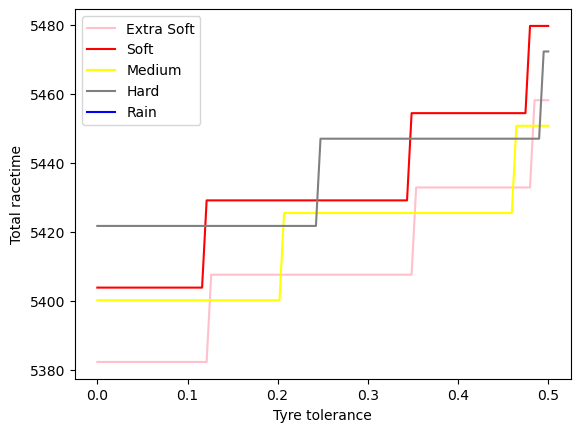

In [21]:
col = {'Extra Soft': 'pink', 'Soft': 'red', 'Medium': 'yellow', 'Hard': 'grey', 'Rain': 'blue'}
grid = np.linspace(0, 0.5, 100)
times = pd.DataFrame([get_strategies(14, x)['Time'] for x in grid])
for tyre in times:
    plt.plot(grid, times[tyre], c = col[tyre], label = tyre)
plt.legend()
plt.xlabel('Tyre tolerance')
plt.ylabel('Total racetime')

In [22]:
get_strategies(14, .2999)

,Stints,Stops,Time,Fuel
Extra Soft,3.809524,3,5407.617333,0.266111
Soft,3.809524,3,5429.137333,0.263358
Medium,2.285714,2,5425.478222,0.433262
Hard,2.162162,2,5446.998222,0.457411
Rain,1.904762,1,NaN,0.522998
